## Triple Chaos Encryption

In [ ]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from math import log

Create an output folder to store the results

In [2]:
os.makedirs("outputs", exist_ok=True)

### Image IO and Plotting Utils

To Load an image from disk as a NumPy array.
- mode='color' => shape (H, W, 3)
- mode='gray'  => shape (H, W)

In [3]:
def load_image(image_path, mode='color'):
    if mode == 'gray':
        pil_img = Image.open(image_path).convert('L')
        return np.array(pil_img)
    else:
        pil_img = Image.open(image_path).convert('RGB')
        return np.array(pil_img)

To save a NumPy array to disk as a PNG

In [4]:
def save_image(img_array, out_path):
    if len(img_array.shape) == 2:
        out_img = Image.fromarray(img_array.astype('uint8'), 'L')
    else:
        out_img = Image.fromarray(img_array.astype('uint8'), 'RGB')
    out_img.save(out_path)
    print(f"Saved: {out_path}")

To Display the image and optionally save to 'save_path'.

In [5]:
def show_and_save_image(img_array, title="Image", save_path=None):
    plt.figure(figsize=(5,5))
    if len(img_array.shape) == 2:
        plt.imshow(img_array, cmap='gray', vmin=0, vmax=255)
    else:
        plt.imshow(img_array)
    plt.title(title)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()

To Plot and show the histogram of an image, optionally saves to 'save_path'.

In [6]:
def show_and_save_histogram(img_array, title="Histogram", save_path=None):
    plt.figure()
    if len(img_array.shape) == 2:
        plt.hist(img_array.ravel(), bins=256, range=(0,255), color='gray')
    else:
        colors = ('b','g','r')
        for i, c in enumerate(colors):
            hist = cv2.calcHist([img_array.astype('uint8')],[i],None,[256],[0,256])
            plt.plot(hist, color=c)
    plt.title(title)
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()

To Plot horizontally adjacent pixel correlation, optionally saves to file.

In [8]:
def show_and_save_correlation(img_array, sample_size=1024, title="Correlation", save_path=None):
    
    if len(img_array.shape) == 3:
        gray = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2GRAY)
    else:
        gray = img_array
    h, w = gray.shape
    samples_x = []
    samples_y = []
    for _ in range(sample_size):
        r = random.randint(0, h-1)
        c = random.randint(0, w-2)
        px1 = gray[r, c]
        px2 = gray[r, c+1]
        samples_x.append(px1)
        samples_y.append(px2)
    plt.figure()
    plt.scatter(samples_x, samples_y, s=2)
    
    plt.title(title)
    plt.xlabel("Pixel (r,c)")
    plt.ylabel("Pixel (r,c+1)")
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()

# Chaos Map Functions

### Arnold's Cat Map

One iteration of Arnold's Cat:  
&ensp;&ensp;&ensp;&ensp;x', y' = ((x + y) mod n), ((x + 2*y) mod n)

In [10]:
def arnold_cat_transform(img):
    n = img.shape[0]
    transformed = np.zeros_like(img)
    for x in range(n):
        for y in range(n):
            new_x = (x + y) % n
            new_y = (x + 2*y) % n
            transformed[new_x, new_y] = img[x, y]
    return transformed

Applying Arnold's Cat transform 'iterations' times.

In [11]:
def arnold_cat_encrypt(img_array, iterations):
    h, w = img_array.shape[:2]
    if h != w:
        raise ValueError("Arnold's Cat requires a square image!")
    result = img_array.copy()
    for _ in range(iterations):
        result = arnold_cat_transform(result)
    return result

Estimate period for n x n image returning to original under Arnold's Cat.

In [12]:
def arnold_cat_period(n):
    if (n % 2 == 0) and 5**int(round(log(n/2,5))) == int(n/2):
        return 3*n
    elif 5**int(round(log(n,5))) == int(n):
        return 2*n
    elif (n % 6 == 0) and 5**int(round(log(n/6,5))) == int(n/6):
        return 2*n
    else:
        return int(12*n/7)

Decrypt by continuing from 'iterations' to full period.

In [13]:
def arnold_cat_decrypt(img_array, iterations):
    n = img_array.shape[0]
    per = arnold_cat_period(n)
    result = img_array.copy()
    for i in range(iterations, per):
        result = arnold_cat_transform(result)
    return result

### Henon Map (XOR based)

To Convert a list of bits (0/1) into a list of bytes [0..255]

In [14]:
def bits_to_bytes(bits):
    assert len(bits) % 8 == 0
    out = []
    for i in range(0, len(bits), 8):
        val = 0
        for b in bits[i:i+8]:
            val = (val << 1) | b
        out.append(val)
    return out

Generate 'num_bits' bits from Henon map.

In [15]:
def henon_map_sequence(num_bits, x0=0.1, y0=0.1, a=1.4, b=0.3):
    x = x0
    y = y0
    bits = []
    for _ in range(num_bits):
        x_next = y + 1 - a*(x**2)
        y_next = b*x
        x, y = x_next, y_next
        bits.append(0 if x <= 0.4 else 1)
    return bits

XOR each pixel with Henon-based pseudorandom bytes.

In [16]:
def henon_encrypt(img_array, x0=0.1, y0=0.1):
    shape = img_array.shape
    if len(shape) == 2:
        h, w = shape
        c = 1
    else:
        h, w, c = shape

    total_pixels = h*w
    needed_bytes = total_pixels*c
    needed_bits = needed_bytes*8

    henon_bits = henon_map_sequence(needed_bits, x0, y0)
    henon_stream = bits_to_bytes(henon_bits)

    encrypted = np.zeros_like(img_array)
    idx = 0
    for r in range(h):
        for cc in range(w):
            if c == 1:
                px = img_array[r, cc]
                encrypted[r, cc] = px ^ henon_stream[idx]
                idx += 1
            else:
                px_r, px_g, px_b = img_array[r, cc]
                encrypted[r, cc, 0] = px_r ^ henon_stream[idx]
                encrypted[r, cc, 1] = px_g ^ henon_stream[idx+1]
                encrypted[r, cc, 2] = px_b ^ henon_stream[idx+2]
                idx += 3
    return encrypted

In [17]:
def henon_decrypt(img_array, x0=0.1, y0=0.1):
    return henon_encrypt(img_array, x0, y0)

### Logistic Map

<!-- Generate 'num_values' bytes from logistic map x_{n+1} = r*x_n*(1 - x_n). -->
The logistic map instead uses a nonlinear difference equation to look at discrete time steps. It’s called the logistic map because it maps the population value at any time step to its value at the next time step.

The basic formula is:
(X_t+1) = r.X_t.(1 - X_t)

For this implementation we have included key mixing. The initial values of the chaos map is recalculated after every pixel encryption based on the previous encryption value as well as the key value.

In [ ]:
# def logistic_map_sequence(num_values, r=3.99, seed=0.12345):
#     x = seed
#     out_bytes = []
#     for _ in range(num_values):
#         x = r*x*(1 - x)
#         out_bytes.append(int((x*1e6) % 256))
#     return out_bytes

In [1]:
def getImageMatrix(imageName):
    im = Image.open(imageName) 
    pix = im.load()
    color = 1
    if type(pix[0,0]) == int:
      color = 0
    image_size = im.size 
    image_matrix = []
    for width in range(int(image_size[0])):
        row = []
        for height in range(int(image_size[1])):
                row.append((pix[width,height]))
        image_matrix.append(row)
    return image_matrix, image_size[0], image_size[1],color

In [3]:
def logistic_encrypt(imageName, key):
    N = 256
    key_list = [ord(x) for x in key]
    G = [key_list[0:4] ,key_list[4:8], key_list[8:12]]
    g = []
    R = 1
    for i in range(1,4):
        s = 0
        for j in range(1,5):
            s += G[i-1][j-1] * (10**(-j))
        g.append(s)
        R = (R*s) % 1

    L = (R + key_list[12]/256) % 1
    S_x = round(((g[0]+g[1]+g[2])*(10**4) + L *(10**4)) % 256)
    V1 = sum(key_list)
    V2 = key_list[0]
    for i in range(1,13):
        V2 = V2 ^ key_list[i]
    V = V2/V1

    L_y = (V+key_list[12]/256) % 1
    S_y = round((V+V2+L_y*10**4) % 256)
    C1_0 = S_x
    C2_0 = S_y
    C = round((L*L_y*10**4) % 256)
    C_r = round((L*L_y*10**4) % 256)
    C_g = round((L*L_y*10**4) % 256)
    C_b = round((L*L_y*10**4) % 256)
    x = 4*(S_x)*(1-S_x)
    y = 4*(S_y)*(1-S_y)
    
    imageMatrix,dimensionX, dimensionY, color = getImageMatrix(imageName)
    LogisticEncryptionIm = []
    for i in range(dimensionX):
        row = []
        for j in range(dimensionY):
            while x <0.8 and x > 0.2 :
                x = 4*x*(1-x)
            while y <0.8 and y > 0.2 :
                y = 4*y*(1-y)
            x_round = round((x*(10**4))%256)
            y_round = round((y*(10**4))%256)
            C1 = x_round ^ ((key_list[0]+x_round) % N) ^ ((C1_0 + key_list[1])%N)
            C2 = x_round ^ ((key_list[2]+y_round) % N) ^ ((C2_0 + key_list[3])%N) 
            if color:
              C_r =((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((key_list[6]+imageMatrix[i][j][0]) % N) ^ ((C_r + key_list[7]) % N)
              C_g =((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((key_list[6]+imageMatrix[i][j][1]) % N) ^ ((C_g + key_list[7]) % N)
              C_b =((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((key_list[6]+imageMatrix[i][j][2]) % N) ^ ((C_b + key_list[7]) % N)
              row.append((C_r,C_g,C_b))
              C = C_r

            else:
              C = ((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((key_list[6]+imageMatrix[i][j]) % N) ^ ((C + key_list[7]) % N)
              row.append(C)

            x = (x + C/256 + key_list[8]/256 + key_list[9]/256) % 1
            y = (x + C/256 + key_list[8]/256 + key_list[9]/256) % 1
            for ki in range(12):
                key_list[ki] = (key_list[ki] + key_list[12]) % 256
                key_list[12] = key_list[12] ^ key_list[ki]
        LogisticEncryptionIm.append(row)

    im = Image.new("L", (dimensionX, dimensionY))
    if color:
        im = Image.new("RGB", (dimensionX, dimensionY))
    else: 
        im = Image.new("L", (dimensionX, dimensionY)) # L is for Black and white pixels
      
    pix = im.load()
    for x in range(dimensionX):
        for y in range(dimensionY):
            pix[x, y] = LogisticEncryptionIm[x][y]
    im.save(imageName.split('.')[0] + "_LogisticEnc.png", "PNG")

In [4]:
def logistic_decrypt(imageName, key):
    N = 256
    key_list = [ord(x) for x in key]

    G = [key_list[0:4] ,key_list[4:8], key_list[8:12]]
    g = []
    R = 1
    for i in range(1,4):
        s = 0
        for j in range(1,5):
            s += G[i-1][j-1] * (10**(-j))
        g.append(s)
        R = (R*s) % 1
    
    L_x = (R + key_list[12]/256) % 1
    S_x = round(((g[0]+g[1]+g[2])*(10**4) + L_x *(10**4)) % 256)
    V1 = sum(key_list)
    V2 = key_list[0]
    for i in range(1,13):
        V2 = V2 ^ key_list[i]
    V = V2/V1

    L_y = (V+key_list[12]/256) % 1
    S_y = round((V+V2+L_y*10**4) % 256)
    C1_0 = S_x
    C2_0 = S_y
    
    C = round((L_x*L_y*10**4) % 256)
    I_prev = C
    I_prev_r = C
    I_prev_g = C
    I_prev_b = C
    I = C
    I_r = C
    I_g = C
    I_b = C
    x_prev = 4*(S_x)*(1-S_x)
    y_prev = 4*(L_x)*(1-S_y)
    x = x_prev
    y = y_prev
    imageMatrix,dimensionX, dimensionY, color = getImageMatrix(imageName)

    henonDecryptedImage = []
    for i in range(dimensionX):
        row = []
        for j in range(dimensionY):
            while x <0.8 and x > 0.2 :
                x = 4*x*(1-x)
            while y <0.8 and y > 0.2 :
                y = 4*y*(1-y)
            x_round = round((x*(10**4))%256)
            y_round = round((y*(10**4))%256)
            C1 = x_round ^ ((key_list[0]+x_round) % N) ^ ((C1_0 + key_list[1])%N)
            C2 = x_round ^ ((key_list[2]+y_round) % N) ^ ((C2_0 + key_list[3])%N) 
            if color:
                I_r = ((((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((I_prev_r + key_list[7]) % N) ^ imageMatrix[i][j][0]) + N-key_list[6])%N
                I_g = ((((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((I_prev_g + key_list[7]) % N) ^ imageMatrix[i][j][1]) + N-key_list[6])%N
                I_b = ((((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((I_prev_b + key_list[7]) % N) ^ imageMatrix[i][j][2]) + N-key_list[6])%N
                I_prev_r = imageMatrix[i][j][0]
                I_prev_g = imageMatrix[i][j][1]
                I_prev_b = imageMatrix[i][j][2]
                row.append((I_r,I_g,I_b))
                x = (x +  imageMatrix[i][j][0]/256 + key_list[8]/256 + key_list[9]/256) % 1
                y = (x +  imageMatrix[i][j][0]/256 + key_list[8]/256 + key_list[9]/256) % 1  
            else:
                I = ((((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((I_prev+key_list[7]) % N) ^ imageMatrix[i][j]) + N-key_list[6])%N
                I_prev = imageMatrix[i][j]
                row.append(I)
                x = (x +  imageMatrix[i][j]/256 + key_list[8]/256 + key_list[9]/256) % 1
                y = (x +  imageMatrix[i][j]/256 + key_list[8]/256 + key_list[9]/256) % 1
            for ki in range(12):
                key_list[ki] = (key_list[ki] + key_list[12]) % 256
                key_list[12] = key_list[12] ^ key_list[ki]
        henonDecryptedImage.append(row)
    if color:
        im = Image.new("RGB", (dimensionX, dimensionY))
    else: 
        im = Image.new("L", (dimensionX, dimensionY)) # L is for Black and white pixels
    pix = im.load()
    for x in range(dimensionX):
        for y in range(dimensionY):
            pix[x, y] = henonDecryptedImage[x][y]
    im.save(imageName.split('_')[0] + "_LogisticDec.png", "PNG")

### Individual Chaos Results

### TRIPLE-CHAOS (Logistic -> Arnold -> Henon)

In [21]:
os.makedirs("outputs_lah", exist_ok=True)

In [23]:
def triple_chaos_encrypt(
    img_array,
    arnold_key=10,
    henon_key=(0.1,0.1),
    logistic_key=(3.99, 0.12345)
):
    # 1) Logistic
    r, seed = logistic_key
    step = logistic_encrypt(img_array, r, seed)
    # 2) Arnold
    # step1 = arnold_cat_encrypt(img_array, arnold_key)
    # 3) Henon
    # x0, y0 = henon_key
    # step2 = henon_encrypt(step1, x0, y0)
    return step

In [24]:
def triple_chaos_decrypt(
    cipher_array,
    arnold_key=10,
    henon_key=(0.1,0.1),
    logistic_key=(3.99, 0.12345)
):
    # Reverse order: logistic -> henon -> arnold
    r, seed = logistic_key
    step = logistic_decrypt(cipher_array, r, seed)

    # x0, y0 = henon_key
    # step2 = henon_decrypt(step1, x0, y0)

    # step3 = arnold_cat_decrypt(step2, arnold_key)
    return step

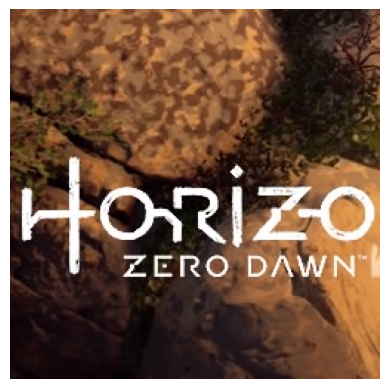

In [ ]:
img = mpimg.imread("input.png")  # Replace with your image path
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
input_image = "input.png"
original = load_image(input_image, mode='color')
original